In [32]:
import nfl_data_py as nfl
import pandas as pd
import os
import urllib.request
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox
from matplotlib.offsetbox import OffsetImage

from PIL import Image
import numpy as np
from io import BytesIO
import requests
# ML Libraryies
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import hvplot.pandas
import plotly.express as px

# Graphing 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.pyplot import figure

In [33]:
#Import Stats from NFL library
qbr = nfl.import_qbr([2023])
weekly_nfl = nfl.import_weekly_data([2023])

Downcasting floats.


In [34]:
# Create DF to get epa rushing and receiving vs d
columns = ['opponent_team', 'receiving_epa', 'rushing_epa']
epa_df = weekly_nfl[columns]

epa_sum_df = epa_df.groupby('opponent_team').sum().reset_index()
epa_sum_df.head()

,opponent_team,receiving_epa,rushing_epa
0,ARI,75.314064,-0.539854
1,ATL,28.855333,-34.790123
2,BAL,-0.525161,-21.073187
3,BUF,25.588522,-10.934500
4,CAR,29.671452,19.830725


In [35]:
# Add the 'receiving_epa' and 'rushing_epa' columns to create 'epa_total'
epa_sum_df['epa_total_d'] = epa_sum_df['receiving_epa'] + epa_sum_df['rushing_epa']


In [36]:
# Create DF to get epa rushing and receiving offense
columns_o = ['recent_team', 'receiving_epa', 'rushing_epa']
epa_df_o = weekly_nfl[columns_o]

epa_sum_df_o = epa_df_o.groupby('recent_team').sum().reset_index()

# Add the 'receiving_epa' and 'rushing_epa' columns to create 'epa_total' offense
epa_sum_df_o['epa_total_offense'] = epa_sum_df_o['receiving_epa'] + epa_sum_df_o['rushing_epa']

In [37]:
# merge both df's together on team

total_epa_sum = epa_sum_df_o.merge(epa_sum_df, left_on='recent_team', right_on='opponent_team', how='inner')
total_epa_sum.head()

,recent_team,receiving_epa_x,rushing_epa_x,epa_total_offense,opponent_team,receiving_epa_y,rushing_epa_y,epa_total_d
0,ARI,0.814341,1.919593,2.733933,ARI,75.314064,-0.539854,74.774208
1,ATL,14.361806,-30.038380,-15.676574,ATL,28.855333,-34.790123,-5.934790
2,BAL,56.003181,-2.002311,54.000870,BAL,-0.525161,-21.073187,-21.598349
3,BUF,75.794487,15.845757,91.640244,BUF,25.588522,-10.934500,14.654022
4,CAR,17.825743,-13.468713,4.357030,CAR,29.671452,19.830725,49.502174


In [38]:
total_epa_sum.head()

,recent_team,receiving_epa_x,rushing_epa_x,epa_total_offense,opponent_team,receiving_epa_y,rushing_epa_y,epa_total_d
0,ARI,0.814341,1.919593,2.733933,ARI,75.314064,-0.539854,74.774208
1,ATL,14.361806,-30.038380,-15.676574,ATL,28.855333,-34.790123,-5.934790
2,BAL,56.003181,-2.002311,54.000870,BAL,-0.525161,-21.073187,-21.598349
3,BUF,75.794487,15.845757,91.640244,BUF,25.588522,-10.934500,14.654022
4,CAR,17.825743,-13.468713,4.357030,CAR,29.671452,19.830725,49.502174


In [39]:
# Get NFL Logos for DF
logos = nfl.import_team_desc()[['team_abbr', 'team_logo_espn']]
logo_paths = []
team_abbr = []
if not os.path.exists("logos"):
    os.makedirs("logos")

for team in range(len(logos)):
    urllib.request.urlretrieve(logos['team_logo_espn'][team], f"logos/{logos['team_abbr'][team]}.tif")
    logo_paths.append(f"logos/{logos['team_abbr'][team]}.tif")
    team_abbr.append(logos['team_abbr'][team])

data = {'team_abbr' : team_abbr, 'logo_path' : logo_paths}
logo_data = pd.DataFrame(data)

complete_epa_df = pd.merge(total_epa_sum, logo_data, left_on = 'recent_team', right_on = 'team_abbr')
complete_epa_df.head()

,recent_team,receiving_epa_x,rushing_epa_x,epa_total_offense,opponent_team,receiving_epa_y,rushing_epa_y,epa_total_d,team_abbr,logo_path
0,ARI,0.814341,1.919593,2.733933,ARI,75.314064,-0.539854,74.774208,ARI,logos/ARI.tif
1,ATL,14.361806,-30.038380,-15.676574,ATL,28.855333,-34.790123,-5.934790,ATL,logos/ATL.tif
2,BAL,56.003181,-2.002311,54.000870,BAL,-0.525161,-21.073187,-21.598349,BAL,logos/BAL.tif
3,BUF,75.794487,15.845757,91.640244,BUF,25.588522,-10.934500,14.654022,BUF,logos/BUF.tif
4,CAR,17.825743,-13.468713,4.357030,CAR,29.671452,19.830725,49.502174,CAR,logos/CAR.tif


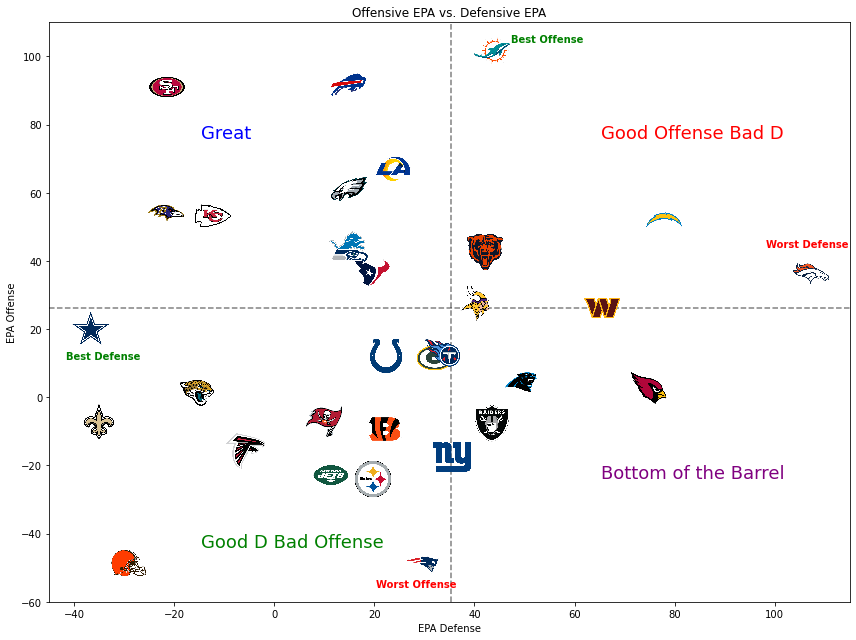

In [74]:
#Create Graph For EPA

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

plt.rcParams["figure.figsize"] = [12, 9]
plt.rcParams["figure.autolayout"] = True

def getImage(path):
    return OffsetImage(plt.imread(path, format="tif"), zoom=.08)

y = complete_epa_df['epa_total_offense']
x = complete_epa_df['epa_total_d']
paths = complete_epa_df['logo_path']

fig, ax = plt.subplots()

# Define quadrant boundaries
x_mid = (x.max() + x.min()) / 2
y_mid = (y.max() + y.min()) / 2

# Quadrant 1 (Top-Right)
for x0, y0, path in zip(x, y, paths):
    if x0 >= x_mid and y0 >= y_mid:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

# Quadrant 2 (Top-Left)
for x0, y0, path in zip(x, y, paths):
    if x0 < x_mid and y0 >= y_mid:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

# Quadrant 3 (Bottom-Left)
for x0, y0, path in zip(x, y, paths):
    if x0 < x_mid and y0 < y_mid:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

# Quadrant 4 (Bottom-Right)
for x0, y0, path in zip(x, y, paths):
    if x0 >= x_mid and y0 < y_mid:
        ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
        ax.add_artist(ab)

plt.axvline(x_mid, color='black', linestyle='--', alpha=0.5)
plt.axhline(y_mid, color='black', linestyle='--', alpha=0.5)

plt.title("Offensive EPA vs. Defensive EPA")
plt.ylabel("EPA Offense")
plt.xlabel("EPA Defense")
plt.grid(False)
plt.xlim(-45, 115)
plt.ylim(-60, 110)
# Quadrant 1 
plt.text(x_mid + 30, y_mid + 50, 'Good Offense Bad D', fontsize=18, color='red')

# Quadrant 2 
plt.text(x_mid - 50, y_mid + 50, 'Great', fontsize=18, color='blue')

# Quadrant 3 
plt.text(x_mid - 50, y_mid - 70, 'Good D Bad Offense', fontsize=18, color='green')

# Quadrant 4 
plt.text(x_mid + 30, y_mid - 50, 'Bottom of the Barrel', fontsize=18, color='purple')

# Worst O
plt.text(x_mid - 15, y_mid - 82, 'Worst Offense', fontsize=10, color='red', fontweight='bold')

# Best O
plt.text(x_mid + 12, y_mid + 78, 'Best Offense', fontsize=10, color='green', fontweight='bold')

# Worst D
plt.text(x_mid - 77, y_mid - 15, 'Best Defense', fontsize=10, color='green', fontweight='bold')

# Best D
plt.text(x_mid + 63, y_mid + 18, 'Worst Defense', fontsize=10, color='red', fontweight='bold')

plt.savefig('total_epa.png')
plt.show()
